<a href="https://colab.research.google.com/github/YasinnSoylu/actt/blob/main/fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ! pip install kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
# ! unzip skin-cancer-mnist-ham10000.zip

In [2]:
#  !pip install timm


In [3]:
from fastai.vision.all import *
from fastai.metrics import *
import pandas as pd
from pathlib import Path
from timm import create_model


%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
csv_path = "/content/HAM10000_metadata.csv"
skin_df = pd.read_csv(csv_path)
skin_df.sort_values(by="image_id")

,lesion_id,image_id,dx,dx_type,age,sex,localization
4349,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk
4263,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity
4217,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk
3587,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk
1451,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest
...,...,...,...,...,...,...,...
1721,HAM_0004304,ISIC_0034316,mel,histo,85.0,male,upper extremity
1888,HAM_0006376,ISIC_0034317,mel,histo,70.0,female,lower extremity
121,HAM_0000344,ISIC_0034318,bkl,histo,55.0,male,trunk
7440,HAM_0000747,ISIC_0034319,nv,histo,30.0,male,trunk


In [5]:
path = Path('/content/')
Path.BASE_PATH = path
path.ls()

(#13) [Path('.config'),Path('hmnist_28_28_L.csv'),Path('skin-cancer-mnist-ham10000.zip'),Path('hmnist_28_28_RGB.csv'),Path('HAM10000_metadata.csv'),Path('kaggle.json'),Path('ham10000_images_part_2'),Path('HAM10000_images_part_2'),Path('ham10000_images_part_1'),Path('hmnist_8_8_L.csv')...]

In [6]:
short_to_full_name_dict = {
    "akiec" : "Bowen's disease", # very early form of skin cancer 
    "bcc" : "basal cell carcinoma" , # basal-cell cancer or white skin cancer
    "bkl" : "benign keratosis-like lesions", # non-cancerous skin tumour
    "df" : "dermatofibroma", # non-cancerous rounded bumps 
    "mel" : "melanoma", # black skin cancer
    "nv" : "melanocytic nevi", # mole non-cancerous
    "vasc" : "vascular lesions", # skin condition
}

In [7]:
# returns only dx and image id column
img_to_class_dict = skin_df.loc[:, ["image_id", "dx"]] 
# returns columns as lists in a dict
img_to_class_dict = img_to_class_dict.to_dict('list')  
# returns a dict mapping image id to disease name
img_to_class_dict = {img_id : short_to_full_name_dict[disease] for img_id,disease in zip(img_to_class_dict['image_id'], img_to_class_dict['dx']) } 
[x for x in img_to_class_dict.items()][:5]

[('ISIC_0027419', 'benign keratosis-like lesions'),
 ('ISIC_0025030', 'benign keratosis-like lesions'),
 ('ISIC_0026769', 'benign keratosis-like lesions'),
 ('ISIC_0025661', 'benign keratosis-like lesions'),
 ('ISIC_0031633', 'benign keratosis-like lesions')]

In [8]:
# path.stem returns the filename without suffix
def get_label_from_dict(path):
    return img_to_class_dict[path.stem] 

In [9]:
dblock = DataBlock(
    # Designation the independent and dependent variables
    blocks = (ImageBlock, CategoryBlock), 
    # To get a list of those files,and returns a list of all of the images in that path
    get_items = get_image_files, 
    # Split our training and validation sets randomly
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    # We are telling fastai what function to call to create the labels in our dataset, in our case is independet variable
    get_y = get_label_from_dict,
    # DihedralItem all 4 90 deg roatations and for each: 
    #2 horizonntal flips -> 8 orientations
    item_tfms=[Resize(448), DihedralItem()],
    # Picks a random scaled crop of an image and resize it to size
    batch_tfms=RandomResizedCrop(size=128, min_scale=0.75, max_scale=1.0))

img_path = "/content/"
# create dataloader using img_path   
data= dblock.dataloaders(img_path, bs=64) # bs = batch size

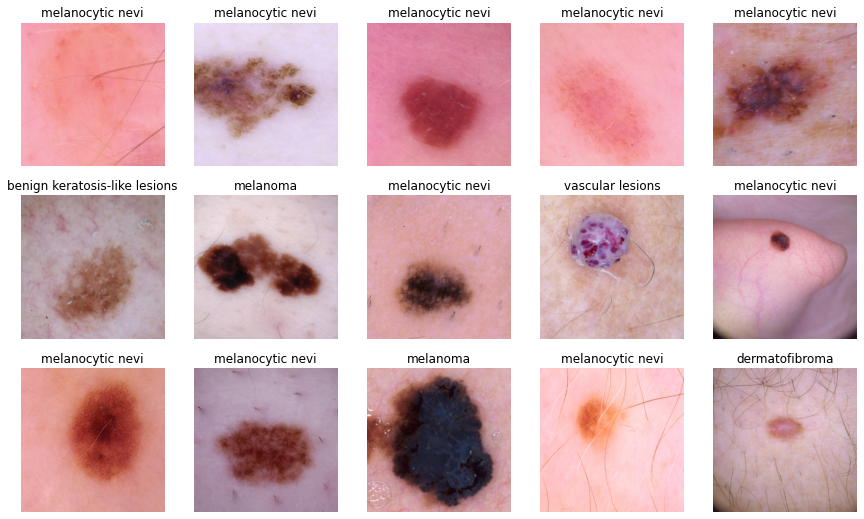

In [10]:
data.show_batch(max_n=15)

In [11]:
print(data.vocab)

["Bowen's disease", 'basal cell carcinoma', 'benign keratosis-like lesions', 'dermatofibroma', 'melanocytic nevi', 'melanoma', 'vascular lesions']


In [12]:
len(data.train_ds), len(data.valid_ds)

(16024, 4006)

#  Train a simple model

In [13]:
dir(models)


['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights',
 'RegNet_X_1_6GF_Weights',
 'R

In [14]:
net = create_model('vgg11', pretrained=True)


In [16]:
learn = vision_learner(data,vgg11,metrics=accuracy)
learn.fine_tune(2)

epoch,train_loss,valid_loss,accuracy,time
0,1.183287,0.786911,0.757614,05:42


epoch,train_loss,valid_loss,accuracy,time
0,0.761711,0.586162,0.801048,10:58
1,0.641658,0.522228,0.823515,10:59


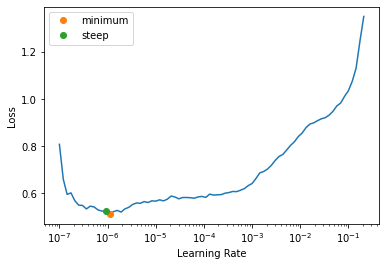

In [17]:
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))


In [18]:
learn = cnn_learner(data,resnet34, metrics = accuracy)
learn.fit_one_cycle(3,1e-5) 

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,2.946227,2.060829,0.290065,05:28
1,2.653078,1.892639,0.398902,05:29
2,2.580472,1.802793,0.435846,05:28


In [19]:
learn = cnn_learner(data,resnet34, metrics = accuracy)
learn.fit_one_cycle(3,1e-4) 

epoch,train_loss,valid_loss,accuracy,time
0,2.249738,1.463480,0.575137,05:32
1,1.683964,1.150204,0.677733,05:29
2,1.510676,1.103367,0.689466,05:29


In [20]:
learn = cnn_learner(data,resnet34, metrics = accuracy)
learn.fit_one_cycle(3,1e-3) 

epoch,train_loss,valid_loss,accuracy,time
0,1.138242,0.654653,0.796555,05:33
1,0.630162,0.447890,0.845731,05:30
2,0.544318,0.422814,0.847479,05:30


In [21]:
learn.unfreeze()

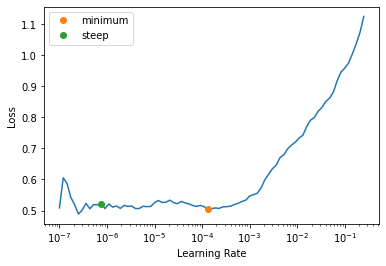

In [22]:
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [24]:
learn.fit_one_cycle(3 ,lr_max=slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.179609,4.916693,0.675986,05:57
1,0.736244,0.670988,0.760609,05:55
2,0.613918,0.568786,0.791313,05:56


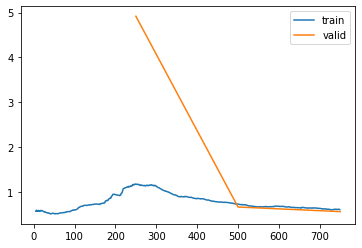

In [25]:
learn.recorder.plot_loss()

In [26]:
learn.save('model1')

Path('models/model1.pth')

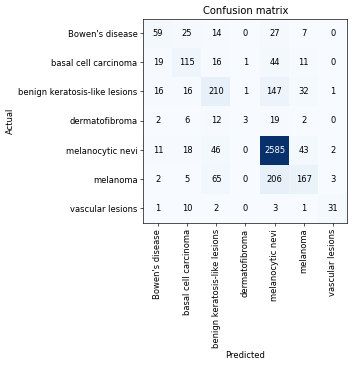

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)